## QRT's online data challenge: reconstruction of liquid asset performance

runtime (on cpu) $\approx$ 1 minute

We build a simple linear regression model to determine the link between two types of assets: liquids and illiquids. We provide returns of 100 illiquid assets and the aim is to predict, for the same day, the sign of the return of 100 liquid assets.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.covariance import oas

## Loading the data

In [2]:
featurespath, targetpath = "./X_train.csv", "./y_train.csv"
featuresdf = pd.read_csv(featurespath, index_col="ID")
targetdf = pd.read_csv(targetpath, index_col="ID")

## Reshaping the data

We transform the data so that each line corresponds to a specific day

In [3]:
idx_ret_features = np.where(featuresdf.columns.str.contains('RET'))[0]
init_ret_features = featuresdf.columns[idx_ret_features]
target_ret_features = ['RET_' + str(a) for a in featuresdf['ID_TARGET'].unique()]
returns = {}
for day in tqdm(featuresdf.ID_DAY.unique()):
    u = featuresdf.loc[featuresdf.ID_DAY == day]
    a = u.iloc[0, idx_ret_features]
    b = targetdf[featuresdf.ID_DAY == day]['RET_TARGET']
    b.index = ['RET_' + str(a) for a in u.ID_TARGET]
    returns[day] = pd.concat([a, b])
returns = pd.DataFrame(returns).T.astype(float)
returns = returns[init_ret_features.tolist() + [c for c in returns.columns if c not in init_ret_features]]

100%|██████████| 2748/2748 [00:04<00:00, 551.18it/s]


## Model

A simple linear regression model
\begin{equation*}
    Y = \alpha + \beta \cdot X^T + \epsilon
\end{equation*}
where $Y = \text{liquid assets}$ and $X = \text{liquid assets}$

In [4]:
n_feats = len(init_ret_features)
n_targets = len(target_ret_features)

class Extended_Beta(nn.Module):
    def __init__(self, W_init):
        super().__init__()
        self.lin = nn.Linear(n_feats, n_targets, dtype=torch.double)
        with torch.no_grad():
            self.lin.weight.copy_(W_init.T)
            self.lin.bias.zero_()
            
    def forward(self, x):
        return self.lin(x)

    def custom_accuracy(self, y_pred, y_true):
        weights = y_true.abs()
        correct = torch.sign(y_pred) == torch.sign(y_true)  
        weighted_correct = (weights * correct).sum()
        return weighted_correct / weights.sum()

## Train/Val split

In [5]:
train_returns, val_returns = train_test_split(returns, test_size=0.3, random_state=1337, shuffle=True)

features = train_returns.columns
train_cov = pd.DataFrame(oas(train_returns.fillna(0))[0], index=features, columns=features)
train_beta = train_cov / np.diag(train_cov)
train_corr = train_returns.corr()

In [6]:
train_proj_matrix = train_beta.T.loc[init_ret_features, target_ret_features]
train_corr_matrix = train_corr.loc[init_ret_features, target_ret_features]

train_coeffs = {}
for id_target in tqdm(target_ret_features):
    x = train_proj_matrix[id_target]
    c = train_corr_matrix[id_target]
    id_init_max = c.abs().idxmax()
    j = id_target.replace('RET_', '')
    train_coeffs[int(j)] = (id_init_max, x[id_init_max])

100%|██████████| 100/100 [00:00<00:00, 10027.98it/s]


## Initialization

Here, the idea is to start the training with weights initialized such that, for each target asset (liquid assets) $y_i$, the model is
\begin{equation*}
    \widehat{y_i} = \beta_j x_j
\end{equation*}
with $x_j$ the illiquid asset that has maximum correlation with $y_i$ (and $\beta_j$ the corresponding $\beta$).

In particular, without training, this model is QRT's benchmark (giving roughly 69.5% on the test set)

In [7]:
W_sparse = np.zeros_like(train_proj_matrix.values)
for j, (feat_name, b) in train_coeffs.items():
    col_idx = target_ret_features.index(f"RET_{j}")
    row_idx = init_ret_features.tolist().index(feat_name)
    W_sparse[row_idx, col_idx] = b

W_init = torch.tensor(W_sparse, dtype=torch.double)
model = Extended_Beta(W_init)

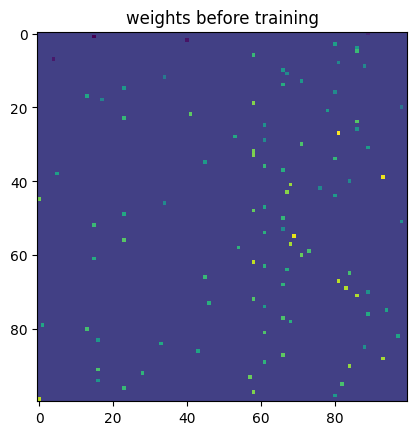

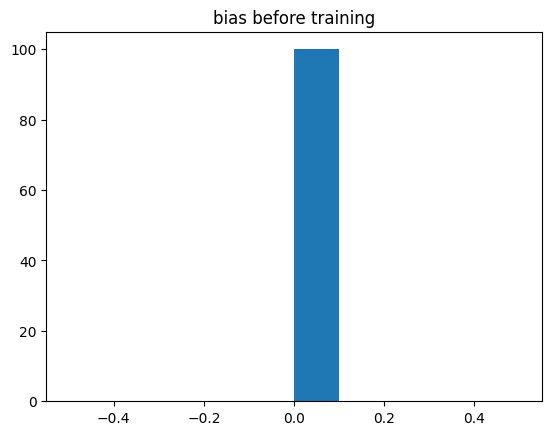

In [8]:
plt.imshow(model.lin.weight.detach().numpy())
plt.title("weights before training")
plt.show()
plt.hist(model.lin.bias.detach().numpy())
plt.title("bias before training")
plt.show()

## Data preparation

In [9]:
train_returns = train_returns.apply(lambda row: row.fillna(row.mean()), axis=1)
val_returns = val_returns.apply(lambda row: row.fillna(row.mean()), axis=1)

X_tr = train_returns[init_ret_features].values
y_tr = train_returns[target_ret_features].values
X_val = val_returns[init_ret_features].values
y_val = val_returns[target_ret_features].values

X_tr, y_tr = torch.from_numpy(X_tr).to(torch.double), torch.from_numpy(y_tr).to(torch.double)
X_val, y_val = torch.from_numpy(X_val).to(torch.double), torch.from_numpy(y_val).to(torch.double)

train_set = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Training

100%|██████████| 25/25 [00:01<00:00, 16.93it/s]


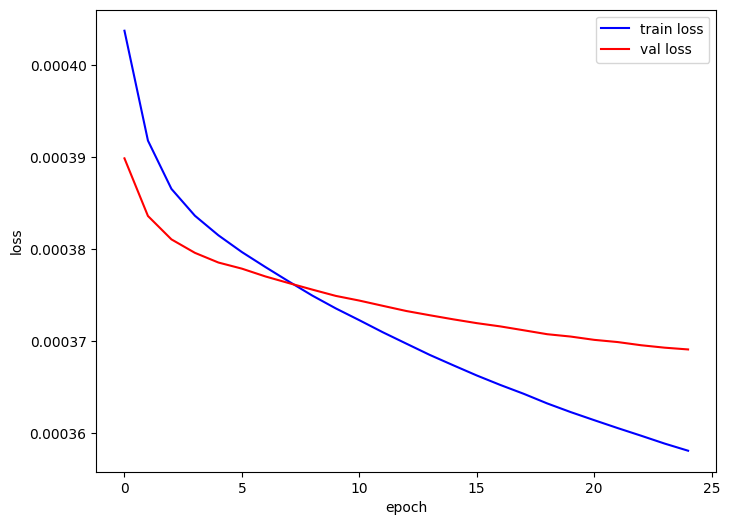

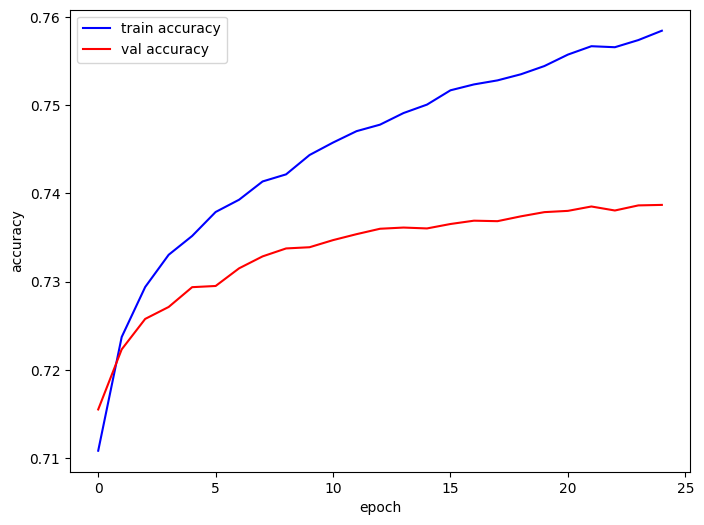

In [11]:
criterion = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metric = model.custom_accuracy

epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in trange(epochs):
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = metric(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        train_acc += acc.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    with torch.no_grad():
        X_val, y_val = X_val.to(device), y_val.to(device)
        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val)
        val_acc = metric(y_pred, y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

plt.figure(figsize=(8, 6))
plt.plot(train_losses, c="b", label="train loss")
plt.plot(val_losses, c="r", label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, c="b", label="train accuracy")
plt.plot(val_accuracies, c="r", label="val accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

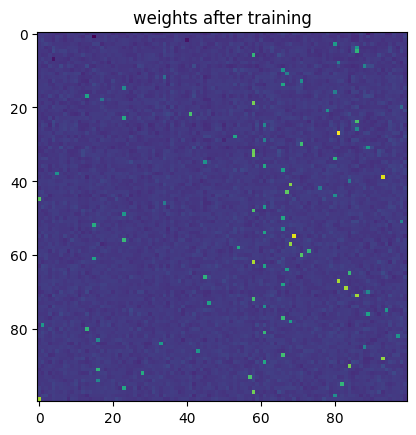

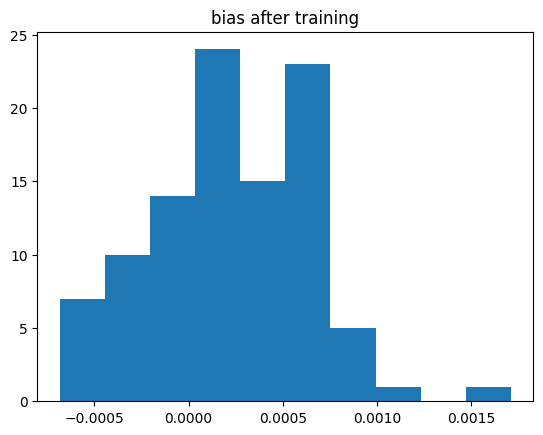

In [12]:
plt.imshow(model.lin.weight.detach().numpy())
plt.title("weights after training")
plt.show()
plt.hist(model.lin.bias.detach().numpy())
plt.title("bias after training")
plt.show()

## Prediction on test data

In [13]:
test_path = "./X_test.csv"
testdf = pd.read_csv(test_path, index_col="ID")

id_targets = testdf["ID_TARGET"].astype(int)
id_days = testdf["ID_DAY"]

X_test_feats = testdf[init_ret_features].copy()
X_test_feats = X_test_feats.apply(lambda row: row.fillna(row.mean()), axis=1)

X_tt = torch.tensor(X_test_feats.values, dtype=torch.double)
preds = model(X_tt).detach().numpy()
dfp = pd.DataFrame(preds, index=X_test_feats.index, columns=target_ret_features)

p = []
for idx in X_test_feats.index:
    tgt_col = f"RET_{id_targets.loc[idx]}"
    p.append(dfp.loc[idx, tgt_col])

pred = pd.Series(p, index=X_test_feats.index, name="RET_TARGET")
pred = pred.fillna( id_days.map(pred.groupby(id_days).mean()) )
pred = np.sign(pred)

In [14]:
pred.name = "RET_TARGET"
pred.index.name = "ID"
pred = pred.astype(int)
pred.to_csv("./submission.csv", header=True)
submission = pd.read_csv("./submission.csv", index_col="ID")

We achieve roughly 73.9% accuracy on the test set: an improvement of roughly $73.9 - 69.5 = 4.4$% upon the benchmark

## Method and further improvements

Given a liquid asset $y_i$, we start from the best possible prediction using one illiquid asset, namely
\begin{equation*}
    \widehat{y_i} = \beta_j * x_j
\end{equation*}
where $x_j$ the illiquid asset that has maximum correlation with $y_i$ and where $\beta_j$ the corresponding $\beta$.

We then let the model learn which additional illiquid asset may (or may not) contribute to better predict the liquid asset; hence giving a model
\begin{equation*}
    \widehat{y_i} = \alpha_i + \sum_{k = 1}^{n_i} \widetilde{\beta_k} * x_k
\end{equation*}
Note: $\widetilde{\beta_j} \approx \beta_j$ (but not equal, see the plots of the weights). In particular, the model modified the contribution of the most correlated illiquid asset.

In some sense, we captured all the "linear information" that the covariance between illiquid/liquid assets could have given. Further improvements (beside tunning the current model):

- try to capture the non-linear information that the covariance may provide (e.g. using tree methods)
- try to capture more linear informations by adding features (e.g. related to co-kurtosis or co-skewness)